In [1]:
%load_ext autoreload
%autoreload 2

import jCMIP as jc
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import copy

In [2]:
# Compute distance between two points:
def comp_dist(lon1,lat1,lon2,lat2):
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)
    dlat = lat2-lat1
    dlon = lon2-lon1
    R = 6371e3 # Radius of Earth
    a = (np.sin(dlat/2))**2 + np.cos(lat1)*np.cos(lat2)*(np.sin(dlon/2))**2
    c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = R*c
    
    return d

# Tidying up the boundary longitudes:
def test_lon(lon1,lon2):
    dlon = lon2-lon1
    newlon2 = copy.deepcopy(lon2)
    newlon2[np.where(dlon > 180)] = lon2[np.where(dlon > 180)] - 360 
    newlon2[np.where(dlon < -180)] = lon2[np.where(dlon < -180)] + 360 
    
    return newlon2

# Compute dz on t-points:
def compdz(Model,dxt,dyt,Tfile):
    dzt = []

    # Check for time invarient cell thickness and/or volume:
    if Model.cmip == '5':
        vtype = 'fx'
    elif Model.cmip == '6':
        vtype = 'Ofx'
    thkFiles = Model.getFiles(var='thkcello', EXP='*',ENS='*',vtype=vtype,gtype='gn')
    volFiles = Model.getFiles(var='volcello', EXP='*',ENS='*',vtype=vtype,gtype='gn')
    areFiles = Model.getFiles(var='areacello',EXP='*',ENS='*',vtype=vtype,gtype='gn')

    print(thkFiles)
    print(volFiles)
    print(areFiles)
    
    if (len(thkFiles) != 0):
        dzt = jc.Oread3Ddata(Model,thkFiles[0],var='thkcello')[:,:,:]
    elif (len(volFiles) != 0):
        vol = jc.Oread3Ddata(Model,volFiles[0],var='volcello')[:,:,:]
        if(len(areFiles) != 0):
            area = jc.Oread2Ddata(Model,areFiles[0],var='areacello')[:,:]
        else:
            area = dxt*dyt
        dzt = vol/np.tile(area,(np.size(vol,axis=0),1,1))*Tmask
    else:
        ncid = Dataset(so,'r')
        dims = ncid.variables['so'].get_dims()
        bounds = ncid.variables[dims[1].name].bounds
        dz_b = ncid.variables[bounds][:,:]
        dz = dz_b[:,1] - dz_b[:,0]
        dzt = np.swapaxes(np.tile(dz,(dims[3].size-np.sum(Model.OextraWE),dims[2].size,1)),0,2)
        ncid.close()
        
        if ((Model.name == 'HadGEM2-AO') | (Model.name == 'FGOALS-gl')):
            dzt = -dzt[::-1,:,:]
        
    dzt[np.isnan(dzt)] = 0
    
    #if (Model.name == 'MRI-CGCM3'):
    #    dzt[-1,:,:] = 0
        
    return dzt

In [25]:
#cmip   = '5'
cmip   = '6'
Clist = jc.readList(('../CMIP' + cmip + 'list'))
Models = list(Clist.keys())

#Model = Clist[Models[59]]
Model = Clist['INM-CM5-H']
print(Model.name)
print(Model.Olon)
print(Model.Olat)
print(Model.Ogrid)
print(Model.Omeshmask)
for nn in Model.notes:
    print(nn)

INM-CM5-H
lon
lat
A-gr1
/gws/pw/j05/wishbone/jmecki/CMIP6/mesh_masks/INM-CM5-H_mesh_mask.nc
21/10/21 - ocean data in gr1
21/10/21 - ocean t/u/v points same lat/lon


In [4]:
# Find Files:
if ((Model.name == 'NorCPM1') | (Model.name == 'NorESM2-LM') | (Model.name == 'NorESM2-MM')):
    vo = Model.getFiles(var='vo',EXP='*',ENS='*',vtype='Omon',gtype='gr')[0]
    uo = Model.getFiles(var='uo',EXP='*',ENS='*',vtype='Omon',gtype='gr')[0]
    so = Model.getFiles(var='so',EXP='*',ENS='*',vtype='Omon',gtype='gr')[0]
    #so = Model.getFiles(var='thetao',EXP='*',ENS='*',vtype='Omon',gtype='gr')[0]
elif ((Model.name == 'INM-CM4-8') | (Model.name == 'INM-CM5-0') | (Model.name == 'INM-CM5-H')):
    vo = Model.getFiles(var='vo',EXP='*',ENS='*',vtype='Omon',gtype='gr1')[0]
    uo = Model.getFiles(var='uo',EXP='*',ENS='*',vtype='Omon',gtype='gr1')[0]
    so = Model.getFiles(var='so',EXP='*',ENS='*',vtype='Omon',gtype='gr1')[0]
    #so = Model.getFiles(var='thetao',EXP='*',ENS='*',vtype='Omon',gtype='gr1')[0]
else:
    vo = Model.getFiles(var='vo',EXP='*',ENS='*',vtype='Omon',gtype='gn')[0]
    uo = Model.getFiles(var='uo',EXP='*',ENS='*',vtype='Omon',gtype='gn')[0]
    so = Model.getFiles(var='so',EXP='*',ENS='*',vtype='Omon',gtype='gn')[0]
    #so = Model.getFiles(var='thetao',EXP='*',ENS='*',vtype='Omon',gtype='gn')[0]

In [5]:
so

'/badc/cmip6/data/CMIP6/HighResMIP/INM/INM-CM5-H/control-1950/r1i1p1f1/Omon/so/gr1/latest/so_Omon_INM-CM5-H_control-1950_r1i1p1f1_gr1_195001-195912.nc'

In [6]:
# Get longitudes and latitudes:
Tlon,Tlat = jc.Olatlon(Model,so,'so')

# lat/lon not given on U/V points:
if ((Model.name == 'ACCESS-OM2') | (Model.name == 'ACCESS-OM2-025')):
    # Read in vertices to get coordinates:
    ncid = Dataset(so,'r')
    Ulon = ncid.variables['vertices_longitude'][:,:,2]
    Ulat = ncid.variables['vertices_latitude'][:,:,2]
    ncid.close()

    Vlon = Ulon
    Vlat = Ulat
elif ((Model.name == 'CAS-ESM2-0')): #(regular grid)
    # Read in vertices to get coordinates:
    ncid = Dataset(so,'r')
    Ulon = ncid.variables['lon_bnds'][:,0]
    Ulat = ncid.variables['lat_bnds'][:,0]
    ncid.close()
    Vlon = Ulon
    Vlat = Ulat
    
    Tlon,Tlat = np.meshgrid(Tlon,Tlat)
    Ulon,Ulat = np.meshgrid(Ulon,Ulat)
    Vlon,Vlat = np.meshgrid(Vlon,Vlat)   
elif ((Model.name == 'CIESM')):
    # Read in vertices to get coordinates:
    ncid = Dataset(so,'r')
    Ulon = ncid.variables['vertices_longitude'][:,:,0]
    Ulat = ncid.variables['vertices_latitude'][:,:,0]
    ncid.close()

    Vlon = Ulon
    Vlat = Ulat
elif ((Model.name == 'GFDL-CM4')):
    # Read in vertices to get coordinates:
    ncid = Dataset(so,'r')
    lon1 = ncid.variables['lon_bnds'][:,:,1]
    lon2 = ncid.variables['lon_bnds'][:,:,2]
    lat1 = ncid.variables['lat_bnds'][:,:,1]
    lat2 = ncid.variables['lat_bnds'][:,:,2]
    lon2 = test_lon(lon1,lon2)
    
    Ulon = (lon1 + lon2)/2
    Ulat = (lat1 + lat2)/2
    
    lon3 = ncid.variables['lon_bnds'][:,:,3]
    lat3 = ncid.variables['lat_bnds'][:,:,3]
    lon2 = test_lon(lon3,lon2)
    
    Vlon = (lon2 + lon3)/2
    Vlat = (lat2 + lat3)/2

    ncid.close()
elif ((Model.name == 'IITM-ESM')):
    # Read in vertices to get coordinates:
    lon1 = copy.deepcopy(Tlon)
    lon2 = copy.deepcopy(lon1)
    lon2 = np.roll(lon2,-1,axis=1)
    lon3 = copy.deepcopy(lon1)
    lon3[:-1,:] = lon3[1:,:]
    lon4 = copy.deepcopy(lon2)
    lon4[:-1,:] = lon4[1:,:]
    
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    Ulon = (lon1 + lon2 + lon3 + lon4)/4
    
    lat1 = copy.deepcopy(Tlat)
    lat2 = copy.deepcopy(lat1)
    lat2 = np.roll(lat2,-1,axis=1)
    lat3 = copy.deepcopy(lat1)
    lat3[:-1,:] = lat3[1:,:]
    lat4 = copy.deepcopy(lat2)
    lat4[:-1,:] = lat4[1:,:]
    
    Ulat = (lat1 + lat2 + lat3 + lat4)/4
    
    Vlon = Ulon
    Vlat = Ulat
elif((Model.name == 'CNRM-CM5') | (Model.name == 'CNRM-CM5-2') | (Model.name == 'EC-EARTH')):
    ncid = Dataset(so,'r')
    lon0 = ncid.variables['lon_vertices'][:,Model.OextraWE[0]:-Model.OextraWE[1],0]
    lat0 = ncid.variables['lat_vertices'][:,Model.OextraWE[0]:-Model.OextraWE[1],0]
    lon3 = ncid.variables['lon_vertices'][:,Model.OextraWE[0]:-Model.OextraWE[1],3]
    lat3 = ncid.variables['lat_vertices'][:,Model.OextraWE[0]:-Model.OextraWE[1],3]
    lon3 = test_lon(lon0,lon3)
    
    Ulon = (lon0 + lon3)/2
    Ulat = (lat0 + lat3)/2
    
    lon1 = ncid.variables['lon_vertices'][:,Model.OextraWE[0]:-Model.OextraWE[1],1]
    lat1 = ncid.variables['lat_vertices'][:,Model.OextraWE[0]:-Model.OextraWE[1],1]
    
    lon1 = test_lon(lon0,lon1)
    Vlon = (lon0 + lon1)/2
    Vlat = (lat0 + lat1)/2
    ncid.close()
elif((Model.name == 'FGOALS-s2') | (Model.name == 'FGOALS-gl')):
    ncid = Dataset(so,'r')
    lonb = ncid.variables['lon_bnds'][:,:]
    latb = ncid.variables['lat_bnds'][:,:]
    ncid.close()
    
    Ulon = lonb[:,0]
    Ulat = latb[:,0] 
    
    Vlon = Ulon
    Vlat = Ulat
    
    if Model.Oreg:
        Tlon,Tlat = np.meshgrid(Tlon,Tlat)
        Ulon,Ulat = np.meshgrid(Ulon,Ulat)
        Vlon,Vlat = np.meshgrid(Vlon,Vlat)
elif((Model.name == 'FIO-ESM')):
    # Read in vertices to get coordinates:
    ncid = Dataset(so,'r')
    Ulon = ncid.variables['lon_vertices'][:,:,0]
    Ulat = ncid.variables['lat_vertices'][:,:,0]
    ncid.close()

    Vlon = Ulon
    Vlat = Ulat
elif((Model.name == 'GISS-E2-H') | (Model.name == 'GISS-E2-H-CC')):
    ncid = Dataset(so,'r')
    lonb = ncid.variables['lon_bnds'][:,:]
    latb = ncid.variables['lat_bnds'][:,:]
    ncid.close()
    
    Ulon = lonb[:,1]
    Ulat = latb[:,0] 
    
    Vlon = Ulon
    Vlat = Ulat
    
    if Model.Oreg:
        Tlon,Tlat = np.meshgrid(Tlon,Tlat)
        Ulon,Ulat = np.meshgrid(Ulon,Ulat)
        Vlon,Vlat = np.meshgrid(Vlon,Vlat)
else:
    # Read in lon and lat:
    Ulon,Ulat = jc.Olatlon(Model,uo,'uo')
    Vlon,Vlat = jc.Olatlon(Model,vo,'vo')
    if Model.Oreg:
        Tlon,Tlat = np.meshgrid(Tlon,Tlat)
        Ulon,Ulat = np.meshgrid(Ulon,Ulat)
        Vlon,Vlat = np.meshgrid(Vlon,Vlat)

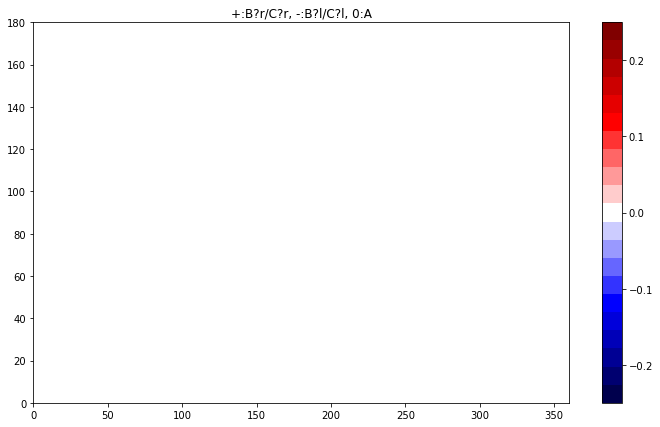

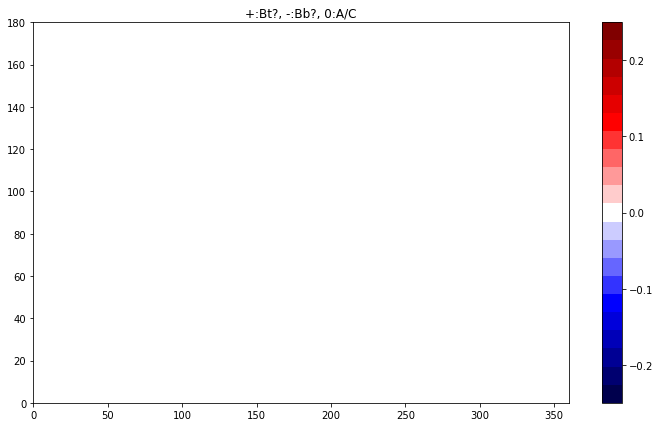

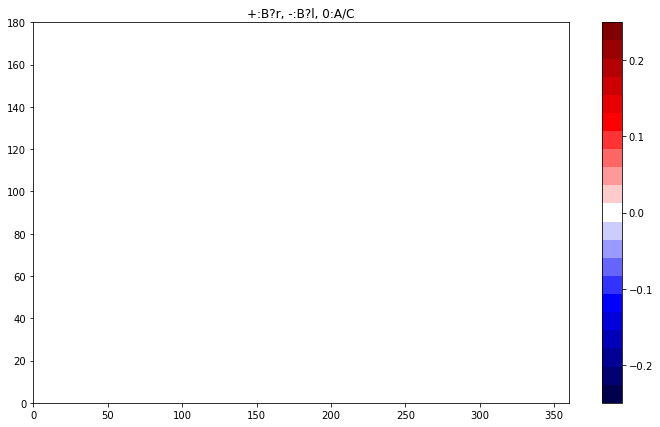

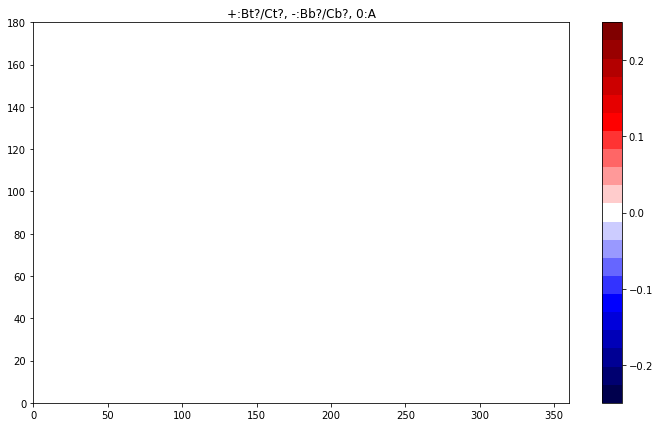

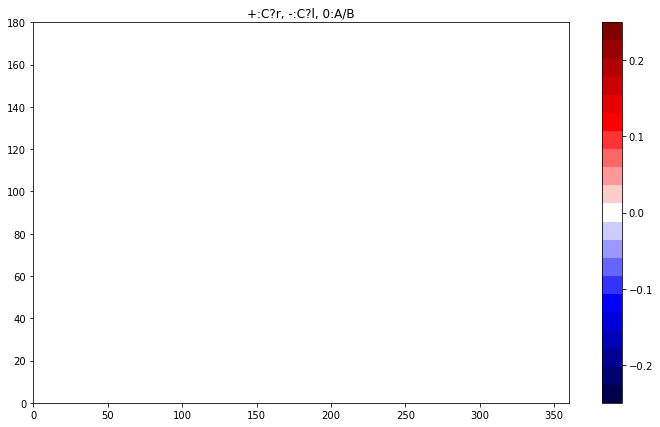

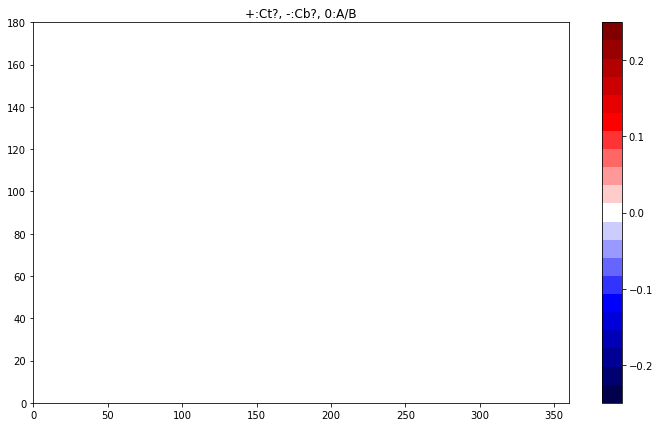

In [7]:
# Check if lon/lat on U and V points is properly given:
# Models with problems:

cmap = plt.get_cmap('seismic',21)

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Ulon-Tlon,vmin=-0.25,vmax=0.25,cmap=cmap)
plt.title('+:B?r/C?r, -:B?l/C?l, 0:A',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Ulat-Tlat,vmin=-0.25,vmax=0.25,cmap=cmap)
plt.title('+:Bt?, -:Bb?, 0:A/C',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Vlon-Tlon,vmin=-0.25,vmax=0.25,cmap=cmap)
plt.title('+:B?r, -:B?l, 0:A/C',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Vlat-Tlat,vmin=-0.25,vmax=0.25,cmap=cmap)
plt.title('+:Bt?/Ct?, -:Bb?/Cb?, 0:A',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Ulon-Vlon,vmin=-0.25,vmax=0.25,cmap=cmap)
plt.title('+:C?r, -:C?l, 0:A/B',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Vlat-Ulat,vmin=-0.25,vmax=0.25,cmap=cmap)
plt.title('+:Ct?, -:Cb?, 0:A/B',fontsize=12)
plt.colorbar()

In [8]:
# Read in mask:
if ((Model.name == 'CESM1-CAM5-SE-LR') | (Model.name == 'CESM2')             | (Model.name == 'CESM2-FV2')     |
    (Model.name == 'CESM2-WACCM')      | (Model.name == 'CESM2-WACCM-FV2')   | (Model.name == 'CNRM-CM6-1-HR') |
    (Model.name == 'EC-Earth3')        | (Model.name == 'EC-Earth3-AerChem') | (Model.name == 'EC-Earth3-CC')  |
    (Model.name == 'EC-Earth3-Veg')    | (Model.name == 'EC-Earth3-Veg-LR')  | (Model.name == 'EC-Earth3P')    |
    (Model.name == 'EC-Earth3P-HR')    | (Model.name == 'FIO-ESM-2-0')       | (Model.name == 'GISS-E2-1-G')   |
    (Model.name == 'GISS-E2-1-G-CC')   | (Model.name == 'IPSL-CM5A2-INCA')   | (Model.name == 'MIROC-ES2L')    |
    (Model.name == 'MIROC6')           | (Model.name == 'SAM0-UNICON')       | (Model.name == 'TaiESM1')       |
    (Model.name == 'CCSM4')            | (Model.name == 'CESM1-BGC')         | (Model.name == 'CESM1-CAM5')    |
    (Model.name == 'CESM1-CAM5-1-FV2') | (Model.name == 'CESM1-FASTCHEM')    | (Model.name == 'CESM1-WACCM')   |
    (Model.name == 'GISS-E2-R')        | (Model.name == 'GISS-E2-R-CC')      | (Model.name == 'MIROC-ESM')     |
    (Model.name == 'MIROC-ESM-CHEM')   | (Model.name == 'CESM1-CAM5-SE-HR')  | (Model.name == 'INM-CM4-8')):
    Tmask     = jc.Oread3Ddata(Model,so,var='so',time=0,mask=True)
    Umask     = jc.Oread3Ddata(Model,uo,var='uo',time=0,mask=True)
    Vmask     = jc.Oread3Ddata(Model,vo,var='vo',time=0,mask=True)
    
    if ((Model.name == 'CNRM-CM6-1-HR')):
        nt = 6
    else:
        nt = 12
    for tt in range(0,nt):
        if tt == 0:
            Ttmp     = np.abs(jc.Oread3Ddata(Model,so,var='so',time=tt))
            Utmp     = np.abs(jc.Oread3Ddata(Model,uo,var='uo',time=tt))
            Vtmp     = np.abs(jc.Oread3Ddata(Model,vo,var='vo',time=tt))
        else:
            Ttmp     = Ttmp + np.abs(jc.Oread3Ddata(Model,so,var='so',time=tt))
            Utmp     = Utmp + np.abs(jc.Oread3Ddata(Model,uo,var='uo',time=tt))
            Vtmp     = Vtmp + np.abs(jc.Oread3Ddata(Model,vo,var='vo',time=tt))

    Tmask[np.where(Ttmp == 0 )] = 0
    Umask[np.where(Utmp == 0 )] = 0
    Vmask[np.where(Vtmp == 0 )] = 0
elif ((Model.name == 'EC-EARTH')):
    # data is not masked properly:
    for tt in range(0,12):
        if tt == 0:
            Tmask     = np.abs(jc.Oread3Ddata(Model,so,var='so',time=tt))
            Umask     = np.abs(jc.Oread3Ddata(Model,uo,var='uo',time=tt))
            Vmask     = np.abs(jc.Oread3Ddata(Model,vo,var='vo',time=tt))
        else:
            Tmask     = Tmask + np.abs(jc.Oread3Ddata(Model,so,var='so',time=tt))
            Umask     = Umask + np.abs(jc.Oread3Ddata(Model,uo,var='uo',time=tt))
            Vmask     = Vmask + np.abs(jc.Oread3Ddata(Model,vo,var='vo',time=tt))
    
    Tmask = 1-(Tmask == 0)
    Umask = 1-(Umask == 0)
    Vmask = 1-(Vmask == 0)
elif ((Model.name == 'MIROC4h') | (Model.name == 'MIROC5')):
    # data is not masked properly:
    for tt in range(0,6):
        if tt == 0:
            Tmask     = np.abs(jc.Oread3Ddata(Model,so,var='so',time=tt))
            Umask     = np.abs(jc.Oread3Ddata(Model,uo,var='uo',time=tt))
            Vmask     = np.abs(jc.Oread3Ddata(Model,vo,var='vo',time=tt))
        else:
            Tmask     = Tmask + np.abs(jc.Oread3Ddata(Model,so,var='so',time=tt))
            Umask     = Umask + np.abs(jc.Oread3Ddata(Model,uo,var='uo',time=tt))
            Vmask     = Vmask + np.abs(jc.Oread3Ddata(Model,vo,var='vo',time=tt))
    
    Tmask = 1-(Tmask == 0)
    Umask = 1-(Umask == 0)
    Vmask = 1-(Vmask == 0)
elif ((Model.name == 'MRI-CGCM3')):
    # data is not masked properly:
    for tt in range(0,12):
        if tt == 0:
            Tmask     = np.abs(jc.Oread3Ddata(Model,so,var='so',time=tt))
            Umask     = np.abs(jc.Oread3Ddata(Model,uo,var='uo',time=tt))
            Vmask     = np.abs(jc.Oread3Ddata(Model,vo,var='vo',time=tt))
        else:
            Tmask     = Tmask + np.abs(jc.Oread3Ddata(Model,so,var='so',time=tt))
            Umask     = Umask + np.abs(jc.Oread3Ddata(Model,uo,var='uo',time=tt))
            Vmask     = Vmask + np.abs(jc.Oread3Ddata(Model,vo,var='vo',time=tt))
    
    Tmask = 1-(Tmask == 0)
    Umask = 1-(Umask == 0)
    Vmask = 1-(Vmask == 0)
elif ((Model.name == 'MRI-ESM1')):
    # data is not masked properly:
    for tt in range(0,12):
        if tt == 0:
            Tmask     = np.abs(jc.Oread3Ddata(Model,so,var='so',time=tt))
            Umask     = np.abs(jc.Oread3Ddata(Model,uo,var='uo',time=tt))
            Vmask     = np.abs(jc.Oread3Ddata(Model,vo,var='vo',time=tt))
        else:
            Tmask     = Tmask + np.abs(jc.Oread3Ddata(Model,so,var='so',time=tt))
            Umask     = Umask + np.abs(jc.Oread3Ddata(Model,uo,var='uo',time=tt))
            Vmask     = Vmask + np.abs(jc.Oread3Ddata(Model,vo,var='vo',time=tt))
    
    Tmask = 1-(Tmask == 0)
    Umask = 1-(Umask == 0)
    Vmask = 1-(Vmask == 0)
else:
    Tmask     = jc.Oread3Ddata(Model,so,var='so',time=0,mask=True)
    Umask     = jc.Oread3Ddata(Model,uo,var='uo',time=0,mask=True)
    Vmask     = jc.Oread3Ddata(Model,vo,var='vo',time=0,mask=True)
    
print(np.sum(Tmask))
print(np.sum(Umask))
print(np.sum(Vmask))

1132005
1132005
1132005


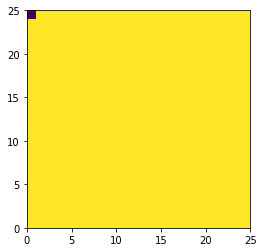

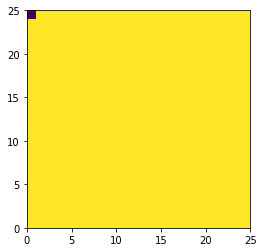

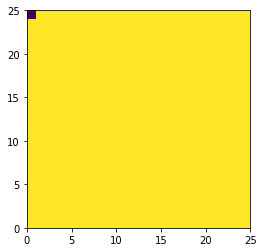

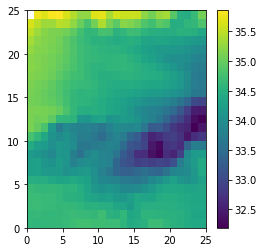

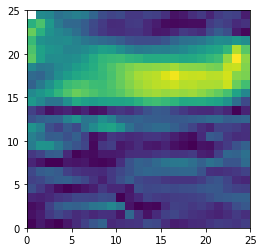

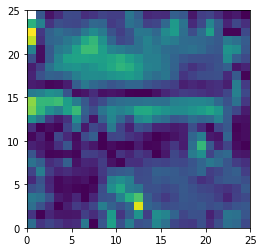

In [9]:
#imin = 270
#imax = 330
#jmin = 320
#jmax = 380
imin = 50
imax = 75
jmin = 75
jmax = 100
#imin = 200
#imax = 250
#jmin = 200
#jmax = 250
#imin = 0
#imax = 50
#jmin = 0
#jmax = 50
#imin = 1100
#imax = 1300
#jmin = 800
#jmax = 1000

fig = plt.figure(figsize=(4,4))
plt.pcolormesh(Tmask[0,jmin:jmax,imin:imax])
fig = plt.figure(figsize=(4,4))
plt.pcolormesh(Umask[0,jmin:jmax,imin:imax])
fig = plt.figure(figsize=(4,4))
plt.pcolormesh(Vmask[0,jmin:jmax,imin:imax])
sod    = jc.Oread3Ddata(Model,so,var='so',time=0)
sod = np.ma.masked_where(sod > 1e15,sod)
uod    = jc.Oread3Ddata(Model,uo,var='uo',time=0)
uod = np.ma.masked_where(uod > 1e15,uod)
vod    = jc.Oread3Ddata(Model,vo,var='vo',time=0)
vod = np.ma.masked_where(vod > 1e15,vod)
fig = plt.figure(figsize=(4,4))
plt.pcolormesh(np.abs(sod[0,jmin:jmax,imin:imax]))
plt.colorbar()
fig = plt.figure(figsize=(4,4))
plt.pcolormesh(np.abs(uod[0,jmin:jmax,imin:imax]))
fig = plt.figure(figsize=(4,4))
plt.pcolormesh(np.abs(vod[0,jmin:jmax,imin:imax]))

(33, 180, 360)
(33, 180, 360)
(33, 180, 360)


(0.0, 200.0)

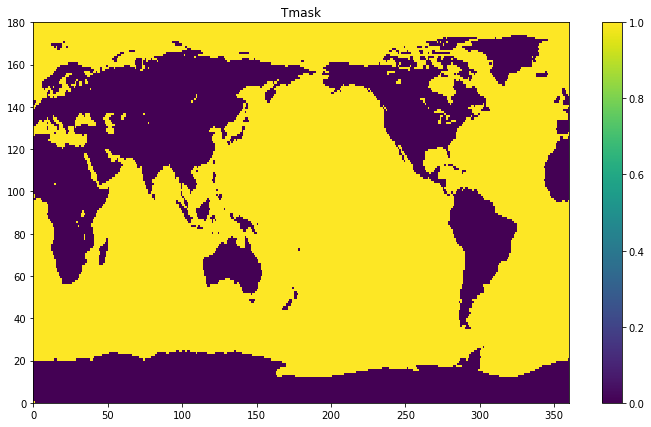

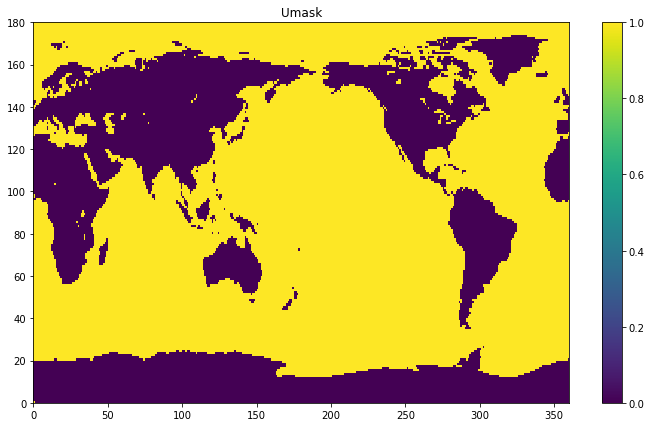

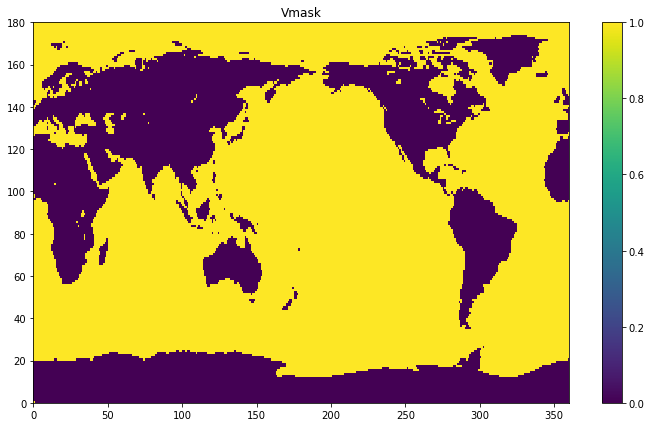

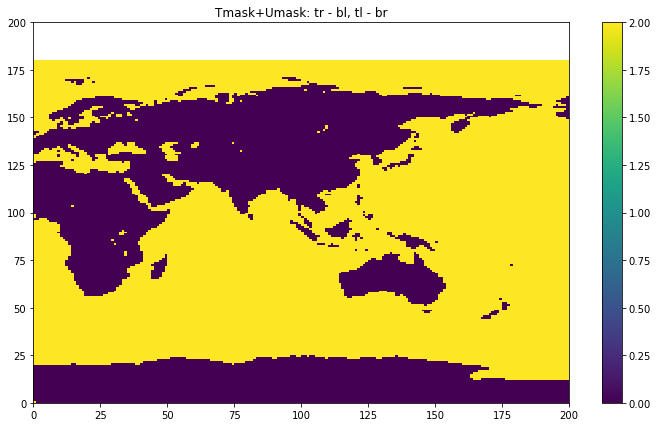

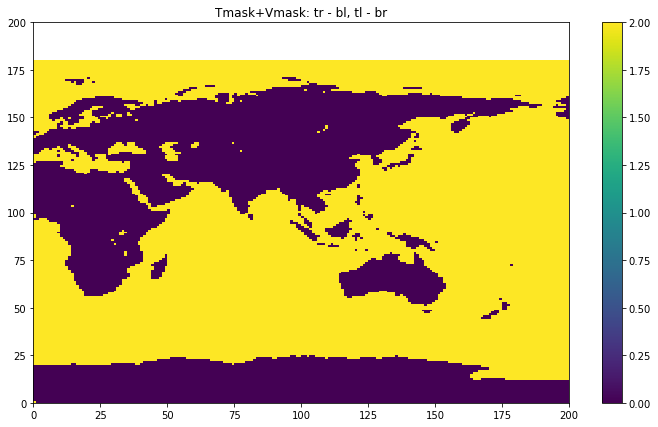

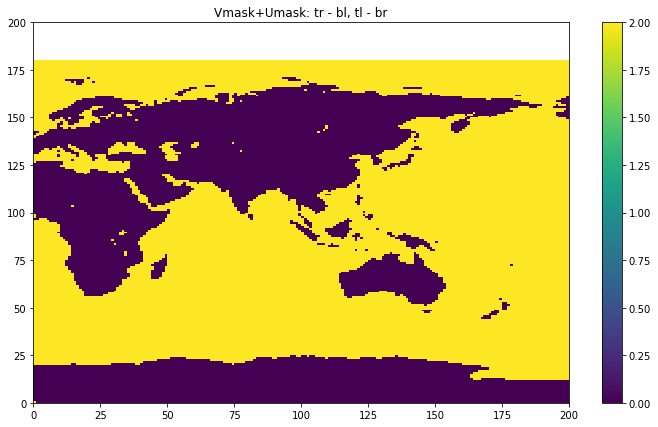

In [10]:
print(np.shape(Tmask))
print(np.shape(Umask))
print(np.shape(Vmask))

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Tmask[0,:,:])
plt.title('Tmask',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Umask[0,:,:])
plt.title('Umask',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Vmask[0,:,:])
plt.title('Vmask',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Tmask[0,:,:]+Umask[0,:,:])
plt.title('Tmask+Umask: tr - bl, tl - br',fontsize=12)
plt.colorbar()
plt.xlim([0,200])
plt.ylim([0,200])

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Tmask[0,:,:]+Vmask[0,:,:])
plt.title('Tmask+Vmask: tr - bl, tl - br',fontsize=12)
plt.colorbar()
plt.xlim([0,200])
plt.ylim([0,200])

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(Vmask[0,:,:]+Umask[0,:,:])
plt.title('Vmask+Umask: tr - bl, tl - br',fontsize=12)
plt.colorbar()
plt.xlim([0,200])
plt.ylim([0,200])

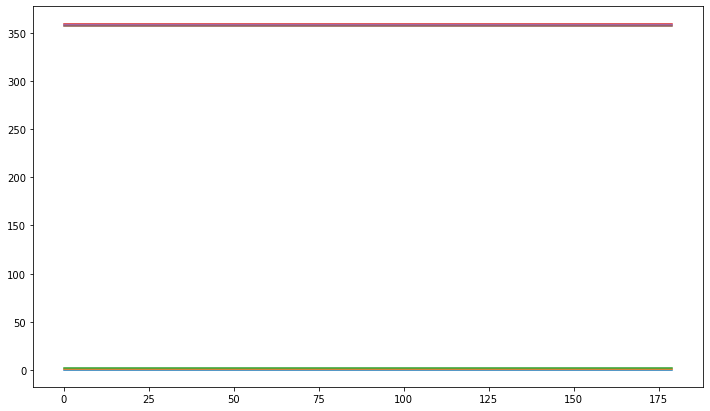

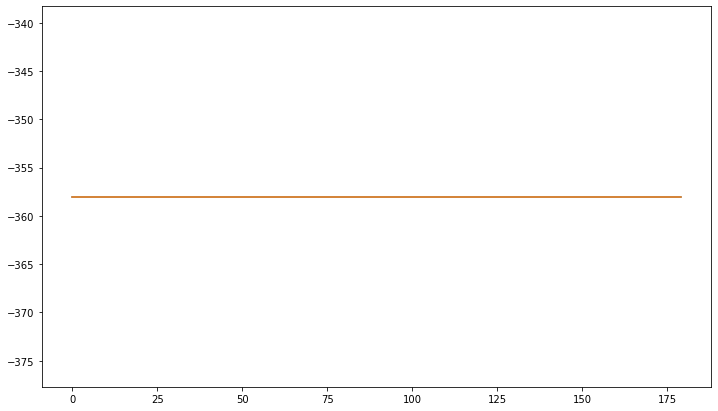

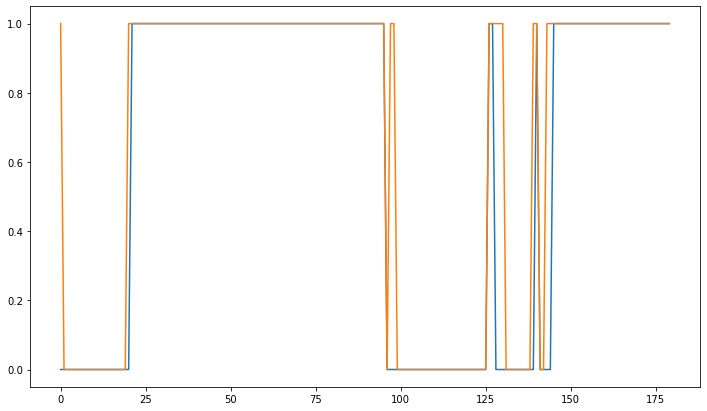

In [11]:
fig = plt.figure(figsize=(12,7))
plt.plot(Tlon[:,0])
plt.plot(Tlon[:,1])
plt.plot(Tlon[:,2])
plt.plot(Tlon[:,-1])
plt.plot(Tlon[:,-2])
plt.plot(Tlon[:,-3])
#plt.xlim([0,100])
#plt.ylim([-0.2,0.2])
#plt.ylim([50,70])
#plt.ylim([0,10])
#plt.ylim([350,360])

fig = plt.figure(figsize=(12,7))
plt.plot(Tlon[:,0]-Tlon[:,-2])
plt.plot(Tlon[:,1]-Tlon[:,-1])

fig = plt.figure(figsize=(12,7))
plt.plot(Tmask[0,:,-1])
plt.plot(Tmask[0,:,0])

In [12]:
# Compute grid information for A model grid:
if Model.Ogrid[0] == 'A':
    # T boxes:
    if ((Model.name == 'FGOALS-g2') | (Model.name == 'GEOS-5')    | (Model.name == 'CFSv2-2011') |
        (Model.name == 'INM-CM4-8') | (Model.name == 'INM-CM5-0') | (Model.name == 'INM-CM5-H')):
        ncid = Dataset(so,'r')
        lonb = ncid.variables['lon_bnds'][:,:]
        latb = ncid.variables['lat_bnds'][:,:]
        ncid.close()
        
        if ((Model.name == 'GEOS-5')):
            lonb[179,1] = 179.5
            lonb[180,0] = 179.5
        
        lon0,lat0 = np.meshgrid(lonb[:,0],latb[:,0])
        lon1,lat1 = np.meshgrid(lonb[:,1],latb[:,1])
        lon1 = test_lon(lon0,lon1)
        
        dxt = comp_dist(lon0,Tlat,lon1,Tlat)
        dyt = comp_dist(Tlon,lat0,Tlon,lat1)
    elif ((Model.name == 'TaiESM1-TIMCOM')):
        ncid = Dataset(so,'r')
        lon0 = ncid.variables['vertices_longitude'][:,:,0]
        lat0 = ncid.variables['vertices_latitude'][:,:,0]
        lon1 = ncid.variables['vertices_longitude'][:,:,1]
        lat1 = ncid.variables['vertices_latitude'][:,:,1]
        lon2 = ncid.variables['vertices_longitude'][:,:,2]
        lat2 = ncid.variables['vertices_latitude'][:,:,2]
        lon3 = ncid.variables['vertices_longitude'][:,:,3]
        lat3 = ncid.variables['vertices_latitude'][:,:,3]
        ncid.close()
        
        lon1 = test_lon(lon0,lon1)
        Tx1  = (lon1+lon0)/2
        Ty1  = (lat1+lat0)/2
        
        lon2 = test_lon(lon3,lon2)
        Tx2  = (lon3+lon2)/2
        Ty2  = (lat3+lat2)/2
        
        dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
        
        lon3 = test_lon(lon0,lon3)
        Tx1  = (lon3+lon0)/2
        Ty1  = (lat3+lat0)/2
        
        lon2 = test_lon(lon1,lon2)
        Tx2  = (lon1+lon2)/2
        Ty2  = (lat1+lat2)/2
        
        dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
        
    dzt = compdz(Model,dxt,dyt,so)*Tmask
        
    # U/V boxes:
    dxu = dxt
    dxv = dxt
    dyu = dyt
    dyv = dyt
    dzu = dzt
    dzv = dzt

[]
[]
[]


In [13]:
# Compute grid information for Btr model grid:
if Model.Ogrid == 'Btr':
    # T boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # top right
    lon2 = copy.deepcopy(Ulon) # top left
    lon2 = np.roll(lon2,1,axis=1)
    lon3 = copy.deepcopy(Ulon) # bottom right
    lon3[1:,:] = lon1[:-1,:]
    lon4 = copy.deepcopy(lon2) # bottom left
    lon4[1:,:] = lon2[:-1,:]
    
    lat1 = copy.deepcopy(Ulat) # top right
    lat2 = copy.deepcopy(Ulat) # top left
    lat2 = np.roll(lat2,1,axis=1)
    lat3 = copy.deepcopy(Ulat) # bottom right
    lat3[1:,:] = lat1[:-1,:]
    lat4 = copy.deepcopy(lat2) # bottom left
    lat4[1:,:] = lat2[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2 
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so[0])*Tmask
  
    # U/V boxes:
    # Compute corners used for computation:
    lon4 = copy.deepcopy(Vlon) # top right
    lon3 = copy.deepcopy(Vlon) # top left
    lon3 = np.roll(lon3,-1,axis=1)
    lon2 = copy.deepcopy(Vlon) # bottom right
    lon2[:-1,:] = lon4[1:,:]
    lon1 = copy.deepcopy(lon3) # bottom left
    lon1[:-1,:] = lon3[1:,:]
    
    lat4 = copy.deepcopy(Vlat) # top right
    lat3 = copy.deepcopy(Vlat) # top left
    lat3 = np.roll(lat3,-1,axis=1)
    lat2 = copy.deepcopy(Vlat) # bottom right
    lat2[:-1,:] = lat4[1:,:]
    lat1 = copy.deepcopy(lat3) # bottom left
    lat1[:-1,:] = lat3[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360)
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dxv = dxu
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dyv = dyu
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    dzu3 = copy.deepcopy(dzt)
    dzu4 = copy.deepcopy(dzt)

    dzu2[:,:-1,:] = dzt[:,1:,:]
    dzu3 = np.roll(dzu3,-1,axis=2)
    dzu4[:,:-1,:] = dzu3[:,1:,:]

    #dzu  = (dzu1+dzu2+dzu3+dzu4)/4
    dzu = np.minimum(dzu1,dzu2)
    dzu = np.minimum(dzu,dzu3)
    dzu = np.minimum(dzu,dzu4)

    dzv = dzu

In [14]:
# Compute grid information for Btr model grid:
if Model.Ogrid == 'Btl':
    # T boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # top right
    lon2 = copy.deepcopy(Ulon) # top left
    lon2 = np.roll(lon2,-1,axis=1)
    lon3 = copy.deepcopy(Ulon) # bottom right
    lon3[1:,:] = lon1[:-1,:]
    lon4 = copy.deepcopy(lon2) # bottom left
    lon4[1:,:] = lon2[:-1,:]
    
    lat1 = copy.deepcopy(Ulat) # top right
    lat2 = copy.deepcopy(Ulat) # top left
    lat2 = np.roll(lat2,-1,axis=1)
    lat3 = copy.deepcopy(Ulat) # bottom right
    lat3[1:,:] = lat1[:-1,:]
    lat4 = copy.deepcopy(lat2) # bottom left
    lat4[1:,:] = lat2[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2 
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so[0])*Tmask
  
    # U/V boxes:
    # Compute corners used for computation:
    lon4 = copy.deepcopy(Vlon) # top right
    lon3 = copy.deepcopy(Vlon) # top left
    lon3 = np.roll(lon3,1,axis=1)
    lon2 = copy.deepcopy(Vlon) # bottom right
    lon2[:-1,:] = lon4[1:,:]
    lon1 = copy.deepcopy(lon3) # bottom left
    lon1[:-1,:] = lon3[1:,:]
    
    lat4 = copy.deepcopy(Vlat) # top right
    lat3 = copy.deepcopy(Vlat) # top left
    lat3 = np.roll(lat3,1,axis=1)
    lat2 = copy.deepcopy(Vlat) # bottom right
    lat2[:-1,:] = lat4[1:,:]
    lat1 = copy.deepcopy(lat3) # bottom left
    lat1[:-1,:] = lat3[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360)
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dxv = dxu
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dyv = dyu
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    dzu3 = copy.deepcopy(dzt)
    dzu4 = copy.deepcopy(dzt)

    dzu2[:,:-1,:] = dzt[:,1:,:]
    dzu3 = np.roll(dzu3,1,axis=2)
    dzu4[:,:-1,:] = dzu3[:,1:,:]

    dzu = np.minimum(dzu1,dzu2)
    dzu = np.minimum(dzu,dzu3)
    dzu = np.minimum(dzu,dzu4)

    dzv = dzu

In [15]:
# Compute grid information for Bbl model grid:
if Model.Ogrid == 'Bbl':
    # T boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # bottom left
    lon2 = copy.deepcopy(Ulon) # top left
    lon2 = np.roll(lon2,-1,axis=1)
    lon3 = copy.deepcopy(Ulon) # bottom right
    lon3[:-1,:] = lon1[1:,:]
    lon4 = copy.deepcopy(lon2) # bottom left
    lon4[:-1,:] = lon2[1:,:]
    
    lat1 = copy.deepcopy(Ulat) # top right
    lat2 = copy.deepcopy(Ulat) # top left
    lat2 = np.roll(lat2,-1,axis=1)
    lat3 = copy.deepcopy(Ulat) # bottom right
    lat3[:-1,:] = lat1[1:,:]
    lat4 = copy.deepcopy(lat2) # bottom left
    lat4[:-1,:] = lat2[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2 
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so)*Tmask
    
    # U/V boxes:
    # Compute corners used for computation:
    lon4 = copy.deepcopy(Vlon) # top right
    lon3 = copy.deepcopy(Vlon) # top left
    lon3 = np.roll(lon3,1,axis=1)
    lon2 = copy.deepcopy(Vlon) # bottom right
    lon2[1:,:] = lon4[:-1,:]
    lon1 = copy.deepcopy(lon3) # bottom left
    lon1[1:,:] = lon3[:-1,:]
    
    lat4 = copy.deepcopy(Vlat) # top right
    lat3 = copy.deepcopy(Vlat) # top left
    lat3 = np.roll(lat3,1,axis=1)
    lat2 = copy.deepcopy(Vlat) # bottom right
    lat2[1:,:] = lat4[:-1,:]
    lat1 = copy.deepcopy(lat3) # bottom left
    lat1[1:,:] = lat3[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360)
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dxv = dxu
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dyv = dyu
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    dzu3 = copy.deepcopy(dzt)
    dzu4 = copy.deepcopy(dzt)

    dzu2[:,1:,:] = dzt[:,:-1,:]
    dzu3 = np.roll(dzu3,-1,axis=2)
    dzu4[:,1:,:] = dzu3[:,:-1,:]

    dzu = np.minimum(dzu1,dzu2)
    dzu = np.minimum(dzu,dzu3)
    dzu = np.minimum(dzu,dzu4)

    dzv = dzu

In [16]:
# Compute grid information for Bbl model grid:
if Model.Ogrid == 'Bbr':
    # T boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # bottom right
    lon2 = copy.deepcopy(Ulon) # top right
    lon2 = np.roll(lon2,1,axis=1)
    lon3 = copy.deepcopy(Ulon) # bottom left
    lon3[:-1,:] = lon1[1:,:]
    lon4 = copy.deepcopy(lon2) # bottomleft
    lon4[:-1,:] = lon2[1:,:]
    
    lat1 = copy.deepcopy(Ulat) # top left
    lat2 = copy.deepcopy(Ulat) # top right
    lat2 = np.roll(lat2,1,axis=1)
    lat3 = copy.deepcopy(Ulat) # bottom left
    lat3[:-1,:] = lat1[1:,:]
    lat4 = copy.deepcopy(lat2) # bottom right
    lat4[:-1,:] = lat2[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2 
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so)*Tmask
    
    # U/V boxes:
    # Compute corners used for computation:
    lon4 = copy.deepcopy(Vlon) # top left
    lon3 = copy.deepcopy(Vlon) # top right
    lon3 = np.roll(lon3,-1,axis=1)
    lon2 = copy.deepcopy(Vlon) # bottom left
    lon2[1:,:] = lon4[:-1,:]
    lon1 = copy.deepcopy(lon3) # bottom right
    lon1[1:,:] = lon3[:-1,:]
    
    lat4 = copy.deepcopy(Vlat) # top left
    lat3 = copy.deepcopy(Vlat) # top right
    lat3 = np.roll(lat3,-1,axis=1)
    lat2 = copy.deepcopy(Vlat) # bottom left
    lat2[1:,:] = lat4[:-1,:]
    lat1 = copy.deepcopy(lat3) # bottom right
    lat1[1:,:] = lat3[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360)
    lon2 = test_lon(lon1,lon2)
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon1,lon4)
    
    # Compute dx:
    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dxv = dxu
    
    # Compute dy:
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    dyv = dyu
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    dzu3 = copy.deepcopy(dzt)
    dzu4 = copy.deepcopy(dzt)

    dzu2[:,1:,:] = dzt[:,:-1,:]
    dzu3 = np.roll(dzu3,1,axis=2)
    dzu4[:,1:,:] = dzu3[:,:-1,:]

    dzu = np.minimum(dzu1,dzu2)
    dzu = np.minimum(dzu,dzu3)
    dzu = np.minimum(dzu,dzu4)

    dzv = dzu

In [17]:
# Compute grid information for Ctr model grid:
if Model.Ogrid[:3] == 'Ctr':
    # T boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Ulon) # right
    Tx2 = copy.deepcopy(Ulon) # left
    Tx2 = np.roll(Tx2,1,axis=1)
    
    Ty1 = copy.deepcopy(Ulat) # right
    Ty2 = copy.deepcopy(Ulat) # left
    Ty2 = np.roll(Ty2,1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Vlon) # top
    Tx2 = copy.deepcopy(Vlon) # bottom
    Tx2[1:,:] = Tx1[:-1,:]
    
    Ty1 = copy.deepcopy(Vlat) # top
    Ty2 = copy.deepcopy(Vlat) # bottom
    Ty2[1:,:] = Ty1[:-1,:]
 
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so)*Tmask

    # U boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # left
    Tx2 = copy.deepcopy(Tlon) # right
    Tx2 = np.roll(Tx2,-1,axis=1)
    
    Ty1 = copy.deepcopy(Tlat) # left
    Ty2 = copy.deepcopy(Tlat) # right
    Ty2 = np.roll(Ty2,-1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Vlon) # top left
    lon2 = copy.deepcopy(Vlon) # top Right
    lon2 = np.roll(lon2,-1,axis=1)
    lon3 = copy.deepcopy(Vlon) # bottom left
    lon3[1:,:] = lon1[:-1,:]
    lon4 = copy.deepcopy(lon2) # bottom right
    lon4[1:,:] = lon2[:-1,:]
    
    lat1 = copy.deepcopy(Vlat) # top left
    lat2 = copy.deepcopy(Vlat) # top Right
    lat2 = np.roll(lat2,-1,axis=1)
    lat3 = copy.deepcopy(Vlat) # bottom left
    lat3[1:,:] = lat1[:-1,:]
    lat4 = copy.deepcopy(lat2) # bottom right
    lat4[1:,:] = lat2[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon4 = test_lon(lon3,lon4)
    
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    
    dzu2 = np.roll(dzu2,-1,axis=2)

    dzu = np.minimum(dzu1,dzu2)*Umask
        
    # V boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # bottom right
    lon2 = copy.deepcopy(Ulon) # bottom left
    lon2 = np.roll(lon2,1,axis=1)
    lon3 = copy.deepcopy(Ulon) # top right
    lon3[:-1,:] = lon1[1:,:]
    lon4 = copy.deepcopy(lon2) # top left
    lon4[:-1,:] = lon2[1:,:]
    
    lat1 = copy.deepcopy(Ulat) # bottom right
    lat2 = copy.deepcopy(Ulat) # bottom left
    lat2 = np.roll(lat2,1,axis=1)
    lat3 = copy.deepcopy(Ulat) # top right
    lat3[:-1,:] = lat1[1:,:]
    lat4 = copy.deepcopy(lat2) # top left
    lat4[:-1,:] = lat2[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon2,lon4)

    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # bottom
    Tx2 = copy.deepcopy(Tlon) # top
    Tx2[:-1,:] = Tx1[1:,:]
    
    Ty1 = copy.deepcopy(Tlat) # bottom
    Ty2 = copy.deepcopy(Tlat) # top
    Ty2[:-1,:] = Ty1[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzv1 = copy.deepcopy(dzt)
    dzv2 = copy.deepcopy(dzt)
    
    dzv2[:-1,:] = dzv1[1:,:]

    dzv = np.minimum(dzv1,dzv2)*Vmask    

In [18]:
# Compute grid information for Cbr model grid:
if Model.Ogrid[:3] == 'Cbr':
    # T boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Ulon) # right
    Tx2 = copy.deepcopy(Ulon) # left
    Tx2 = np.roll(Tx2,1,axis=1)
    
    Ty1 = copy.deepcopy(Ulat) # right
    Ty2 = copy.deepcopy(Ulat) # left
    Ty2 = np.roll(Ty2,1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Vlon) # bottom
    Tx2 = copy.deepcopy(Vlon) # top
    Tx2[:-1,:] = Tx1[1:,:]
    
    Ty1 = copy.deepcopy(Vlat) # bottom
    Ty2 = copy.deepcopy(Vlat) # top
    Ty2[:-1,:] = Ty1[1:,:]
 
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so)*Tmask

    # U boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # left
    Tx2 = copy.deepcopy(Tlon) # right
    Tx2 = np.roll(Tx2,-1,axis=1)
    
    Ty1 = copy.deepcopy(Tlat) # left
    Ty2 = copy.deepcopy(Tlat) # right
    Ty2 = np.roll(Ty2,-1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Vlon) # bottom left
    lon2 = copy.deepcopy(Vlon) # bottom Right
    lon2 = np.roll(lon2,-1,axis=1)
    lon3 = copy.deepcopy(Vlon) # top left
    lon3[:-1,:] = lon1[1:,:]
    lon4 = copy.deepcopy(lon2) # top right
    lon4[:-1,:] = lon2[1:,:]
    
    lat1 = copy.deepcopy(Vlat) # bottom left
    lat2 = copy.deepcopy(Vlat) # bottom Right
    lat2 = np.roll(lat2,-1,axis=1)
    lat3 = copy.deepcopy(Vlat) # top left
    lat3[:-1,:] = lat1[1:,:]
    lat4 = copy.deepcopy(lat2) # top right
    lat4[:-1,:] = lat2[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon4 = test_lon(lon3,lon4)
    
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    
    dzu2 = np.roll(dzu2,-1,axis=2)

    dzu = np.minimum(dzu1,dzu2)*Umask
        
    # V boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # top right
    lon2 = copy.deepcopy(Ulon) # top left
    lon2 = np.roll(lon2,1,axis=1)
    lon3 = copy.deepcopy(Ulon) # bottom right
    lon3[1:,:] = lon1[:-1,:]
    lon4 = copy.deepcopy(lon2) # bottom left
    lon4[1:,:] = lon2[:-1,:]
    
    lat1 = copy.deepcopy(Ulat) # top right
    lat2 = copy.deepcopy(Ulat) # top left
    lat2 = np.roll(lat2,1,axis=1)
    lat3 = copy.deepcopy(Ulat) # bottom right
    lat3[1:,:] = lat1[:-1,:]
    lat4 = copy.deepcopy(lat2) # bottom left
    lat4[1:,:] = lat2[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon2,lon4)

    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # top
    Tx2 = copy.deepcopy(Tlon) # bottom
    Tx2[1:,:] = Tx1[:-1,:]
    
    Ty1 = copy.deepcopy(Tlat) # top
    Ty2 = copy.deepcopy(Tlat) # bottom
    Ty2[1:,:] = Ty1[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzv1 = copy.deepcopy(dzt)
    dzv2 = copy.deepcopy(dzt)
    
    dzv2[1:,:] = dzv1[:-1,:]

    dzv = np.minimum(dzv1,dzv2)*Vmask  

In [19]:
# Compute grid information for Cbr model grid:
if Model.Ogrid[:3] == 'Cbl':
    # T boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Ulon) # left
    Tx2 = copy.deepcopy(Ulon) # right
    Tx2 = np.roll(Tx2,-1,axis=1)
    
    Ty1 = copy.deepcopy(Ulat) # left
    Ty2 = copy.deepcopy(Ulat) # right
    Ty2 = np.roll(Ty2,-1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Vlon) # bottom
    Tx2 = copy.deepcopy(Vlon) # top
    Tx2[:-1,:] = Tx1[1:,:]
    
    Ty1 = copy.deepcopy(Vlat) # bottom
    Ty2 = copy.deepcopy(Vlat) # top
    Ty2[:-1,:] = Ty1[1:,:]
 
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyt = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzt = compdz(Model,dxt,dyt,so)*Tmask

    # U boxes:
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # right
    Tx2 = copy.deepcopy(Tlon) # left
    Tx2 = np.roll(Tx2,1,axis=1)
    
    Ty1 = copy.deepcopy(Tlat) # right
    Ty2 = copy.deepcopy(Tlat) # left
    Ty2 = np.roll(Ty2,1,axis=1)
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Vlon) # bottom right
    lon2 = copy.deepcopy(Vlon) # bottom left
    lon2 = np.roll(lon2,1,axis=1)
    lon3 = copy.deepcopy(Vlon) # top right
    lon3[:-1,:] = lon1[1:,:]
    lon4 = copy.deepcopy(lon2) # top left
    lon4[:-1,:] = lon2[1:,:]
    
    lat1 = copy.deepcopy(Vlat) # bottom right
    lat2 = copy.deepcopy(Vlat) # bottom left
    lat2 = np.roll(lat2,1,axis=1)
    lat3 = copy.deepcopy(Vlat) # top right
    lat3[:-1,:] = lat1[1:,:]
    lat4 = copy.deepcopy(lat2) # top left
    lat4[:-1,:] = lat2[1:,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon2 = test_lon(lon1,lon2)
    lon4 = test_lon(lon3,lon4)
    
    Tx1 = (lon1+lon2)/2
    Ty1 = (lat1+lat2)/2
    Tx2 = (lon3+lon4)/2
    Ty2 = (lat3+lat4)/2
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyu = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzu1 = copy.deepcopy(dzt)
    dzu2 = copy.deepcopy(dzt)
    
    dzu2 = np.roll(dzu2,1,axis=2)

    dzu = np.minimum(dzu1,dzu2)*Umask
        
    # V boxes:
    # Compute corners used for computation:
    lon1 = copy.deepcopy(Ulon) # top left
    lon2 = copy.deepcopy(Ulon) # top right
    lon2 = np.roll(lon2,-1,axis=1)
    lon3 = copy.deepcopy(Ulon) # bottom left
    lon3[1:,:] = lon1[:-1,:]
    lon4 = copy.deepcopy(lon2) # bottom right
    lon4[1:,:] = lon2[:-1,:]
    
    lat1 = copy.deepcopy(Ulat) # top left
    lat2 = copy.deepcopy(Ulat) # top right
    lat2 = np.roll(lat2,-1,axis=1)
    lat3 = copy.deepcopy(Ulat) # bottom left
    lat3[1:,:] = lat1[:-1,:]
    lat4 = copy.deepcopy(lat2) # bottom right
    lat4[1:,:] = lat2[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    lon3 = test_lon(lon1,lon3)
    lon4 = test_lon(lon2,lon4)

    Tx1 = (lon1+lon3)/2
    Ty1 = (lat1+lat3)/2
    Tx2 = (lon2+lon4)/2
    Ty2 = (lat2+lat4)/2
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dx:
    dxv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute corners used for computation:
    Tx1 = copy.deepcopy(Tlon) # top
    Tx2 = copy.deepcopy(Tlon) # bottom
    Tx2[1:,:] = Tx1[:-1,:]
    
    Ty1 = copy.deepcopy(Tlat) # top
    Ty2 = copy.deepcopy(Tlat) # bottom
    Ty2[1:,:] = Ty1[:-1,:]
    
    # Check to make sure you don't get too large distances (i.e. 0-360):
    Tx2 = test_lon(Tx1,Tx2)
    
    # Compute dy:
    dyv = comp_dist(Tx1,Ty1,Tx2,Ty2)
    
    # Compute dz:
    dzv1 = copy.deepcopy(dzt)
    dzv2 = copy.deepcopy(dzt)
    
    dzv2[1:,:] = dzv1[:-1,:]

    dzv = np.minimum(dzv1,dzv2)*Vmask  

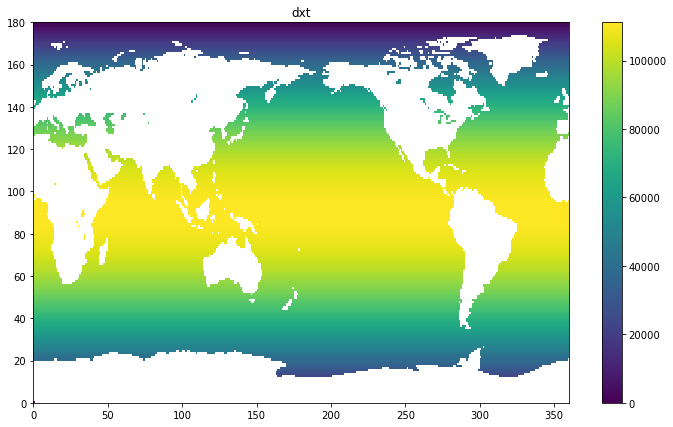

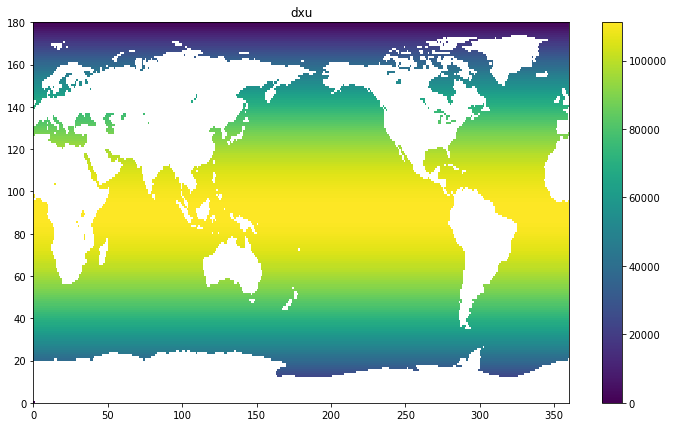

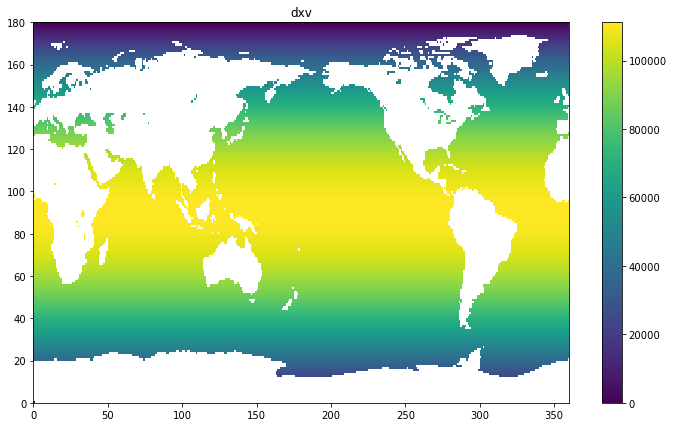

In [20]:
fig = plt.figure(figsize=(12,7))
#plt.pcolormesh(dxt)
plt.pcolormesh(np.ma.masked_where(Tmask[0,:,:]==0,dxt),vmin=0)#,vmax=100000)
plt.title('dxt',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
#plt.pcolormesh(dxu)
plt.pcolormesh(np.ma.masked_where(Umask[0,:,:]==0,dxu),vmin=0)#,vmax=100000)
plt.title('dxu',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
#plt.pcolormesh(dxv)
plt.pcolormesh(np.ma.masked_where(Vmask[0,:,:]==0,dxv),vmin=0)#,vmax=100000)
plt.title('dxv',fontsize=12)
plt.colorbar()

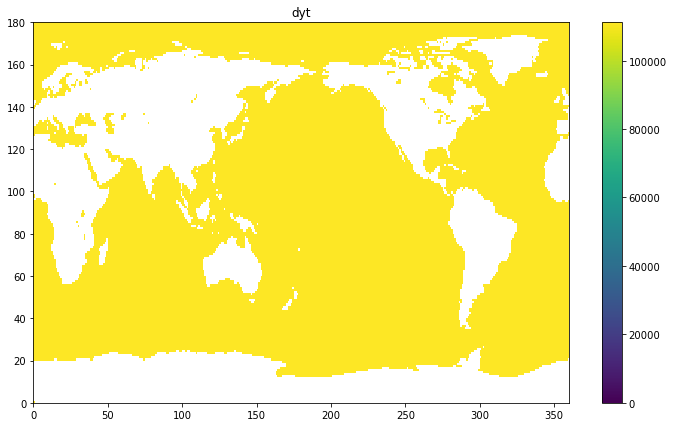

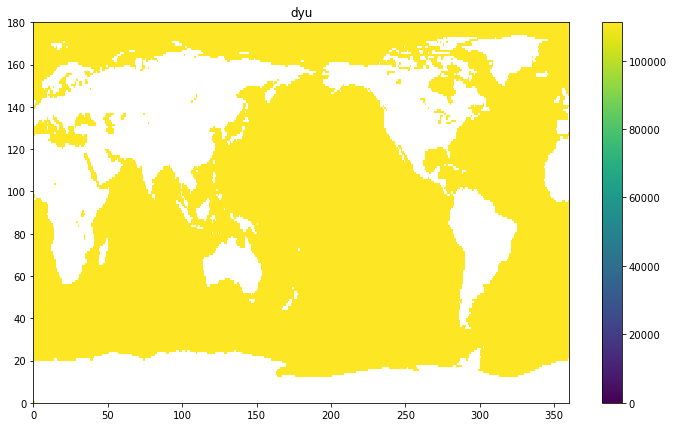

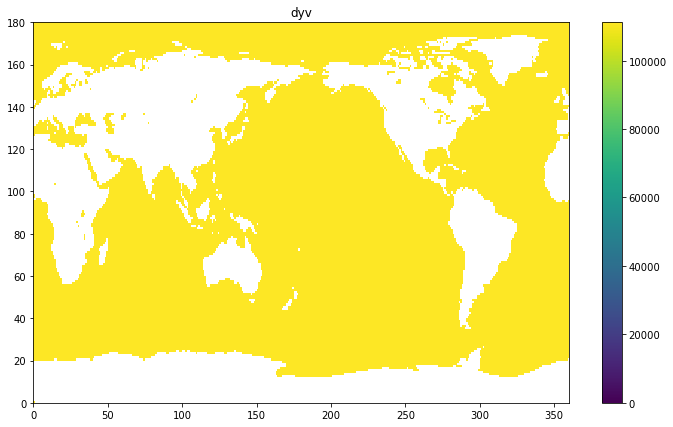

In [21]:
fig = plt.figure(figsize=(12,7))
#plt.pcolormesh(dyt)
plt.pcolormesh(np.ma.masked_where(Tmask[0,:,:]==0,dyt),vmin=0)#,vmax=100000)
plt.title('dyt',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
#plt.pcolormesh(dyu)
plt.pcolormesh(np.ma.masked_where(Umask[0,:,:]==0,dyu),vmin=0)#,vmax=100000)
plt.title('dyu',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
#plt.pcolormesh(dyv)
plt.pcolormesh(np.ma.masked_where(Vmask[0,:,:]==0,dyv),vmin=0)#,vmax=100000)
plt.title('dyv',fontsize=12)
plt.colorbar()

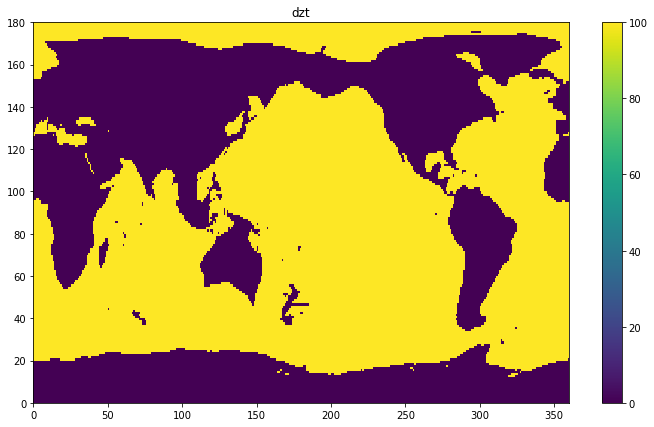

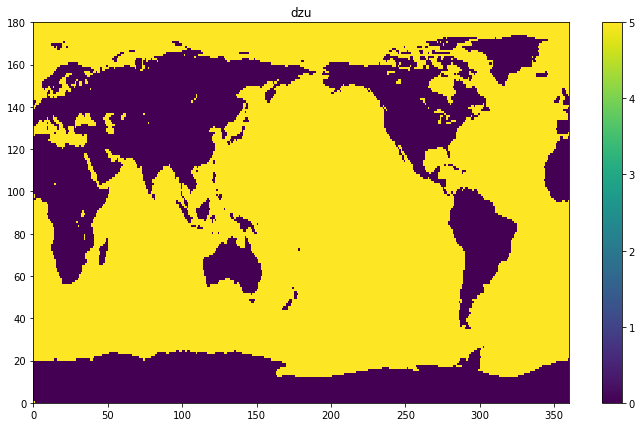

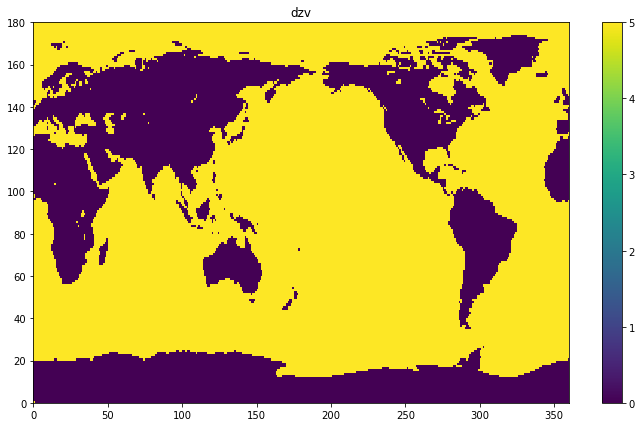

In [22]:
fig = plt.figure(figsize=(12,7))
plt.pcolormesh(dzt[15,:,:])
plt.title('dzt',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(dzt[0,:,:])
plt.title('dzu',fontsize=12)
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.pcolormesh(dzt[0,:,:])
plt.title('dzv',fontsize=12)
plt.colorbar()

In [23]:
# Get file details:

dims  = jc.getDims(so,'so')
ni    = dims[3].size-np.sum(Model.OextraWE)
dlon  = dims[3].name
nj    = dims[2].size
dlat  = dims[2].name
nk    = dims[1].size
dlev  = dims[1].name
dtime = dims[0].name
print(dlev)

ncid = Dataset(so,'r')
dep  = ncid.variables[dlev][:]
ncid.close()

if ((Model.name == 'CFSv2-2011') | (Model.name == 'FGOALS-gl') | (Model.name == 'HadGEM2-AO')):
    dep = dep[::-1]

if np.max(dep) > 10000:
    dep = dep/100
    
print(dep)

lev
[   0.   10.   20.   30.   50.   75.  100.  125.  150.  200.  250.  300.
  400.  500.  600.  700.  800.  900. 1000. 1100. 1200. 1300. 1400. 1500.
 1750. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500.]


In [24]:
#### Save to mesh_mask file:

outfile = (Model.savedir + 'mesh_masks/' + Model.name + '_mesh_mask.nc' )
# Create file:
ncid = Dataset(outfile, 'w', format='NETCDF4')
# dimensions:
ncid.createDimension(dlon,ni)
ncid.createDimension(dlat,nj)
ncid.createDimension(dlev,nk)
ncid.createDimension(dtime,None)
# variables:
ncid.createVariable(dlev,'f8',(dlev,))
ncid.variables[dlev][:] = dep

ncid.createVariable('tlon','f8',(dlat,dlon,))
ncid.variables['tlon'][:,:] = Tlon
ncid.createVariable('tlat','f8',(dlat,dlon,))
ncid.variables['tlat'][:,:] = Tlat
ncid.createVariable('tmask','f8',(dtime,dlev,dlat,dlon,))
ncid.variables['tmask'][0,:,:,:] = Tmask
ncid.createVariable('dxt','f8',(dlat,dlon,))
ncid.variables['dxt'][:,:] = dxt
ncid.createVariable('dyt','f8',(dlat,dlon,))
ncid.variables['dyt'][:,:] = dyt

ncid.createVariable('ulon','f8',(dlat,dlon,))
ncid.variables['ulon'][:,:] = Ulon
ncid.createVariable('ulat','f8',(dlat,dlon,))
ncid.variables['ulat'][:,:] = Ulat
ncid.createVariable('umask','f8',(dtime,dlev,dlat,dlon,))
ncid.variables['umask'][0,:,:,:] = Umask
ncid.createVariable('dxu','f8',(dlat,dlon,))
ncid.variables['dxu'][:,:] = dxu
ncid.createVariable('dyu','f8',(dlat,dlon,))
ncid.variables['dyu'][:,:] = dyu

ncid.createVariable('vlon','f8',(dlat,dlon,))
ncid.variables['vlon'][:,:] = Vlon
ncid.createVariable('vlat','f8',(dlat,dlon,))
ncid.variables['vlat'][:,:] = Vlat
ncid.createVariable('vmask','f8',(dtime,dlev,dlat,dlon,))
ncid.variables['vmask'][0,:,:,:] = Vmask
ncid.createVariable('dxv','f8',(dlat,dlon,))
ncid.variables['dxv'][:,:] = dxv
ncid.createVariable('dyv','f8',(dlat,dlon,))
ncid.variables['dyv'][:,:] = dyv

ncid.createVariable('dzt','f8',(dlev,dlat,dlon,))
ncid.variables['dzt'][:,:,:] = dzt    
ncid.createVariable('dzu','f8',(dlev,dlat,dlon,))
ncid.variables['dzu'][:,:,:] = dzu 
ncid.createVariable('dzv','f8',(dlev,dlat,dlon,))
ncid.variables['dzv'][:,:,:] = dzv 

# close:
ncid.close()

print('-= saved =-')

-= saved =-
